In [13]:
import cv2
import numpy as np
import h5py
from collections import defaultdict
from scipy.spatial.transform import Rotation

import os
from pprint import pprint
import gc

In [14]:
def estimate_pose(kpts0, kpts1, K0, K1, thresh, conf=0.99999):
    if len(kpts0) < 5:
        return None

    f_mean = np.mean([K0[0, 0], K1[1, 1], K0[0, 0], K1[1, 1]])
    norm_thresh = thresh / f_mean

    kpts0 = (kpts0 - K0[[0, 1], [2, 2]][None]) / K0[[0, 1], [0, 1]][None]
    kpts1 = (kpts1 - K1[[0, 1], [2, 2]][None]) / K1[[0, 1], [0, 1]][None]

    E, mask = cv2.findEssentialMat(
        kpts0, kpts1, np.eye(3), threshold=norm_thresh, prob=conf,
        method=cv2.USAC_PROSAC)

    if E is None:
        return None

    best_num_inliers = 0
    ret = None
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(
            _E, kpts0, kpts1, np.eye(3), 1e9, mask=mask)
        if n > best_num_inliers:
            best_num_inliers = n
            ret = (R, t[:, 0], mask.ravel() > 0)
    return ret


def angle_error_mat(R1, R2):
    cos = (np.trace(np.dot(R1.T, R2)) - 1) / 2
    cos = np.clip(cos, -1., 1.)  # numercial errors can make it out of bounds
    return np.rad2deg(np.abs(np.arccos(cos)))


def angle_error_vec(v1, v2):
    n = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1, v2) / n, -1.0, 1.0)))


def compute_pose_error(T_0to1, est_pose):
    R_gt = T_0to1[:3, :3]
    t_gt = T_0to1[:3, 3]
    R = est_pose[:3, :3]
    t = est_pose[:3, 3]
    error_t = angle_error_vec(t, t_gt)
    error_t = np.minimum(error_t, 180 - error_t)  # ambiguity of E estimation
    error_R = angle_error_mat(R, R_gt)
    return error_t, error_R

In [15]:
def load_retrieval_pairs(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        pairs = []
        for line in f:
            pair = line.strip().split(" ")
            pairs.append(pair)
    f.close()
    return pairs

def load_images(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        images = defaultdict(dict)
        for line in f:
            if line.startswith("#"): continue
            timestamp, sensor_id, image_path = line.strip().split(", ")
            images[image_path] = {
                "timestamp": timestamp,
                "sensor_id": sensor_id
            }
    return images

def load_intrinsics(file_path):
    sensors = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            if len(line) < 6: continue
            
            sensor_id = line[0]
            width, height = line[4:6]
            fx, fy, cx, cy = line[6:]
            K = np.array([
                [fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1],
            ], dtype=float)
            
            sensors[sensor_id] = {
                'K': K,
                'width': int(width),
                'height': int(height),
            }
    return sensors

def load_rigs(file_path):
    if file_path is None:
        q = {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}    # No rotate
        t = {'x': 0.0, 'y': 0.0, 'z': 0.0}              # No translate
        q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
        Q = Rotation.from_quat(q_xyzw).as_matrix()
        T = np.array([t['x'], t['y'], t['z']])
        
        cam2rig = np.eye(4)
        cam2rig[:3, :3] = Q
        cam2rig[:3, 3] = T
        
        return {
            'rig_sensors': {
                'cam2rig': cam2rig,
            }
        }
        
    rigs = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            
            # rig_id = line[0].split("_")[-1]
            # sensor_id = line[1].split("/")[-1]
            
            rig_id = line[0]
            sensor_id = line[1]
            q = {
                'w': float(line[2]),
                'x': float(line[3]),
                'y': float(line[4]),
                'z': float(line[5]),
            }
            t = {
                'x': float(line[6]),
                'y': float(line[7]),
                'z': float(line[8]),
            }
            
            q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
            Q = Rotation.from_quat(q_xyzw).as_matrix()
            T = np.array([t['x'], t['y'], t['z']])
            
            cam2rig = np.eye(4)
            cam2rig[:3, :3] = Q
            cam2rig[:3, 3] = T
            
            rigs[rig_id][sensor_id] = {
                'cam2rig': cam2rig,
            }
    return rigs

def load_poses(file_path):
    poses = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            timestamp = line[0]
            device_id = line[1]
            
            q = {
                'w': float(line[2]),
                'x': float(line[3]),
                'y': float(line[4]),
                'z': float(line[5]),
            }
            t = {
                'x': float(line[6]),
                'y': float(line[7]),
                'z': float(line[8]),
            }
            
            q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
            Q = Rotation.from_quat(q_xyzw).as_matrix()
            T = np.array([t['x'], t['y'], t['z']])
            pose = np.eye(4)
            pose[:3, :3] = Q
            pose[:3, 3] = T
            poses[timestamp] = {
                'pose': pose,
                'device_id': device_id
            }
    return poses

def load_keypoints(file_path):
    """
    Load keypoints and descriptors from H5 file.
    
    Supports two structures:
    
    Structure 1 (ios_query):
    - {session}/raw_data/{subsession}/images/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Structure 2 (spot_query):
    - {session}/raw_data/{subsession}/{camera}/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Structure 3 (hl_query):
    - {session}/raw_data/{subsession}/images/{camera}/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Returns nested dicts with flexible structure based on hierarchy depth.
    """
    
    results = defaultdict(dict)
    
    def recursive_load(group, result_key):
        """
        Recursively traverse H5 group and load data when keypoints are found.
        """
        # Check if this group contains keypoints (leaf node)
        if 'keypoints' in group:
            keypoints = np.array(group['keypoints'][:], dtype=np.int32)
            descriptors = np.array(group['descriptors'][:], dtype=np.float32)
            scores = np.array(group['scores'][:], dtype=np.float32)
            image_size = np.array(group['image_size'][:], dtype=np.int32)
            
            results[result_key]['keypoints'] = keypoints
            results[result_key]['descriptors'] = descriptors
            results[result_key]['scores'] = scores
            results[result_key]['image_size'] = image_size
            return
        
        # If not leaf node, iterate through children
        for key in group.keys():
            item = group[key]
            if isinstance(item, h5py.Group):
                # Recurse into this group
                recursive_load(item, f"{result_key}{'/' if result_key != '' else ''}{key}")
    
    with h5py.File(file_path, 'r') as f:
        recursive_load(f, result_key="")
    
    return results

def load_matches(file_path):
    """
    Load matching results from H5 file.
    
    Structure:
    - Group for each query image
      - Group for each map image
        - matches0: matched indices in map image (-1 means no match)
        - matching_scores0: confidence scores for matches
    """
    
    results = defaultdict(dict)
    
    def recursive_load(group, result_key):
        """
        Recursively traverse H5 group and load data when keypoints are found.
        """
        # Check if this group contains keypoints (leaf node)
        if 'matches0' in group:
            matches = np.array(group['matches0'][:], dtype=np.int32)
            scores = np.array(group['matching_scores0'][:], dtype=np.float32)
            
            results[result_key]['matches0'] = matches
            results[result_key]['matching_scores0'] = scores
            return
        
        # If not leaf node, iterate through children
        for key in group.keys():
            item = group[key]
            if isinstance(item, h5py.Group):
                # Recurse into this group
                recursive_load(item, f"{result_key} {key}" if result_key != "" else key)
    
    with h5py.File(file_path, 'r') as f:
        recursive_load(f, result_key="")
    
    return results

In [16]:
query_device = 'ios'
map_device = 'ios'

MATCHES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
all_matches = load_matches(MATCHES_PATH)

In [17]:
all_matches['ios_query-raw_data-ios_2023-07-12_20.46.14_000-images-4793970038.jpg ios_map-raw_data-ios_2023-07-12_20.46.14_002-images-5008076867.jpg']['matching_scores0'].mean()

0.17796852

In [18]:
scores = [v['matching_scores0'].mean() for k, v in all_matches.items()]
sorted(scores, reverse=True)

[0.5690698,
 0.51906514,
 0.5023856,
 0.50113505,
 0.49499694,
 0.4928086,
 0.4877851,
 0.4877808,
 0.4846654,
 0.46596688,
 0.46304852,
 0.46231303,
 0.46175972,
 0.44536358,
 0.4431441,
 0.44138366,
 0.43739352,
 0.43660772,
 0.43392697,
 0.4334773,
 0.43039584,
 0.430152,
 0.42424333,
 0.42299807,
 0.41951266,
 0.41866177,
 0.41595218,
 0.41034254,
 0.40998667,
 0.40983224,
 0.40854436,
 0.40828064,
 0.4065883,
 0.40602294,
 0.40126392,
 0.39847338,
 0.39685613,
 0.39581075,
 0.39576876,
 0.39570823,
 0.39543822,
 0.39383817,
 0.39258492,
 0.39243424,
 0.39188468,
 0.39130193,
 0.38961628,
 0.3880223,
 0.3848509,
 0.38456595,
 0.38441932,
 0.38396317,
 0.38033074,
 0.3802975,
 0.37890202,
 0.376033,
 0.3754747,
 0.37449372,
 0.37376255,
 0.37278372,
 0.37243745,
 0.37144852,
 0.37133962,
 0.37127876,
 0.3708663,
 0.37066525,
 0.3699561,
 0.36945525,
 0.36835182,
 0.36622944,
 0.3658327,
 0.36580545,
 0.36546287,
 0.36475733,
 0.36421412,
 0.36294973,
 0.3628812,
 0.36162463,
 0.3616

In [19]:
def get_K(Ks, images, image):
    sensor_id = images[image]['sensor_id']
    return Ks[sensor_id]['K']

def get_device_id(query_img, timestamp, query_device):
    query_img = query_img.split("/")
    sub = query_img[0]
    
    if query_device == "ios":
        query_device = f"{sub}/cam_phone_{timestamp}"
    if query_device == "hl":
        query_device = f"{sub}/hetrig_{timestamp}"
    if query_device == "spot":
        query_device = f"{sub}/{timestamp}-body"
    
    return query_device

def estimate_poses(pairs, all_matches, all_kpts0, all_kpts1, query_images, map_images, query_Ks, map_Ks):
    est_poses = {}
    for query_img, map_img in pairs:
        query_device = query_img.split("_")[0]
        
        # Matches
        matches, _ = all_matches[f"{query_img.replace('/', '-')} {map_img.replace('/', '-')}"].values()

        # Keypoints
        kpts0 = all_kpts0[query_img]['keypoints']
        kpts1 = all_kpts1[map_img]['keypoints']
            
        # Keep the matching keypoints.
        valid = matches > -1
        mkpts0 = kpts0[valid]
        mkpts1 = kpts1[matches[valid]]

        # Estimate the pose and compute the pose error.
        query_img = "/".join(query_img.split("/")[2:])
        map_img = "/".join(map_img.split("/")[2:])
        
        K0 = get_K(query_Ks, query_images, query_img)
        K1 = get_K(map_Ks, map_images, map_img)

        thresh = 1.  # In pixels relative to resized image size.
        est_pose = estimate_pose(mkpts0, mkpts1, K0, K1, thresh)
        if est_pose is None: continue
                
        query_timestamp = query_images[query_img]['timestamp']
        map_timestamp = map_images[map_img]['timestamp']
        est_poses[f"{query_timestamp}-{map_timestamp}"] = {
            "pose": est_pose,
            "device_id": get_device_id(query_img, query_timestamp, query_device)
        }
    return est_poses

def compute_errors(pairs, query_images, map_images, est_poses, query_poses, map_poses, query_rigs, map_rigs, top, Rt_threshold, r_margin, all_matches):    
    all_err_t, all_err_R = defaultdict(list), defaultdict(list)
    good_pairs, bad_pairs = [], []
    err_Rs, scores = [], []
    for query_img, map_img in pairs:
        #######################################
        _, matching_score = all_matches[f"{query_img.replace('/', '-')} {map_img.replace('/', '-')}"].values()
        matching_score = np.mean(matching_score)
        #######################################
        
        query_img = "/".join(query_img.split("/")[2:])
        map_img = "/".join(map_img.split("/")[2:])
        query_timestamp, query_sensor = query_images[query_img]['timestamp'],  query_images[query_img]['sensor_id']
        map_timestamp, map_sensor = map_images[map_img]['timestamp'],  map_images[map_img]['sensor_id']
        
        if f"{query_timestamp}-{map_timestamp}" not in est_poses: continue
        
        est_pose = est_poses[f"{query_timestamp}-{map_timestamp}"]['pose']
        
        query_pose = get_groundtruth(query_poses, query_rigs, query_timestamp, query_sensor)
        map_pose = get_groundtruth(map_poses, map_rigs, map_timestamp, map_sensor)
        
        # Relative
        T_0to1 = np.linalg.inv(map_pose) @ query_pose
        
        try:
            err_t, err_R = compute_pose_error(T_0to1, est_pose)
        except Exception as e:
            print(est_pose)
            print(e)
        
        # Collect
        all_err_t[query_img].append(err_t)
        all_err_R[query_img].append(err_R)
        
        # Classify
        if err_R < r_margin:
            good_pairs.append((query_img, map_img, str(err_R), str(matching_score)))
        else:
            bad_pairs.append((query_img, map_img, str(err_R), str(matching_score)))
        
        #######################################
        err_Rs.append(err_R)
        scores.append(matching_score)
        #######################################
    
    all_err_t = convert_to_list(all_err_t, top)
    all_err_R = convert_to_list(all_err_R, top)
    
    th_r, th_t = Rt_threshold
    recall = np.mean((all_err_R < th_r) & (all_err_t < th_t))
    return all_err_t.mean(), all_err_R.mean(), recall, good_pairs, bad_pairs, err_Rs, scores

def save_est_poses(file_path, est_poses):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w', encoding='utf-8') as f:
        lines = ""
        lines += "# timestamp, device_id, qw, qx, qy, qz, tx, ty, tz, *covar\n"
        for timestamp, data in est_poses.items():
            line = [timestamp]
            line.append(data['device_id'])
            q_xyzw, t = get_q_t(data['pose'])
            line.append(str(q_xyzw[3]))
            line.append(str(q_xyzw[0]))
            line.append(str(q_xyzw[1]))
            line.append(str(q_xyzw[2]))
            line.append(str(t[0]))
            line.append(str(t[1]))
            line.append(str(t[2]))
            lines += ", ".join(line) + "\n"
        f.write(lines)
    f.close()
    print(f"Saved estimated poses to {file_path}")

def get_q_t(pose):
    Q, T, _ = pose
    r = Rotation.from_matrix(Q)
    q_xyzw = r.as_quat()
    t = T
    return q_xyzw, t
    
def get_groundtruth(poses, rigs, timestamp, cam):
    rig2world = poses[timestamp]['pose']
    rig_id = poses[timestamp]['device_id']
    
    if "rig_sensors" in rigs.keys():
        cam2rig = rigs["rig_sensors"]['cam2rig']
    else:
        cam2rig = rigs[rig_id][cam]['cam2rig']
    
    return rig2world @ cam2rig

def filter_top(results, n=5):
    for k, v in results.items():
        results[k] = sorted(v)[:n]
    return results

def convert_to_list(results, top=5):
    results = filter_top(results, top)
    result_list = []
    for value_list in results.values():
        result_list.extend(value_list)
    return np.array(result_list)

def save_pairs(pairs, save_dir, type):
    save_path = f"{save_dir}/{type}_pairs.txt"
    with open(save_path, 'w', encoding='utf-8') as f:
        lines = "# query_img, map_img, R_err\n"
        #######################################
        lines = "# query_img, map_img, R_err, matching_score\n"
        #######################################
        for pair in pairs:
            line = ", ".join(pair)
            lines += line + '\n'
        f.write(lines)
    print(f"Saved {type} pairs to {save_path}")
    f.close()

In [20]:
def evaluate_pair(query_device, map_device, top, Rt_threshold, r_margin):
    # Pairs
    PAIRS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/pair_selection/{query_device}_query/{map_device}_map/megaloc/pairs.txt"
    pairs = load_retrieval_pairs(PAIRS_PATH)

    # Images
    QUERY_IMAGES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/images.txt"
    MAP_IMAGES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/images.txt"
    query_images = load_images(QUERY_IMAGES_PATH)
    map_images = load_images(MAP_IMAGES_PATH)
    
    SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
    SAVE_PATH = f"{SAVE_DIR}/prosac_est_poses.txt"
    
    if not os.path.exists(SAVE_PATH):
        # Keypoints
        KPTS0_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/extraction/{query_device}_query/superpoint/features.h5"
        all_kpts0 = load_keypoints(KPTS0_PATH)
        KPTS1_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/extraction/{map_device}_map/superpoint/features.h5"
        all_kpts1 = load_keypoints(KPTS1_PATH)

        # Matches
        MATCHES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
        all_matches = load_matches(MATCHES_PATH)

        # Intrinsics
        QUERY_SENSORS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
        MAP_SENSORS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
        query_Ks = load_intrinsics(QUERY_SENSORS_PATH)
        map_Ks = load_intrinsics(MAP_SENSORS_PATH)
        
        est_poses = estimate_poses(pairs, all_matches, all_kpts0, all_kpts1, query_images, map_images, query_Ks, map_Ks)
        save_est_poses(SAVE_PATH, est_poses)
        est_poses = load_poses(SAVE_PATH)
    else:
        #######################################
        MATCHES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
        all_matches = load_matches(MATCHES_PATH)
        #######################################
        est_poses = load_poses(SAVE_PATH)
        
    # Poses
    QUERY_POSES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
    MAP_POSES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
    query_poses = load_poses(QUERY_POSES_PATH)
    map_poses = load_poses(MAP_POSES_PATH)

    # Rigs
    QUERY_RIGS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
    MAP_RIGS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
    query_rigs = load_rigs(QUERY_RIGS_PATH)
    map_rigs = load_rigs(MAP_RIGS_PATH)
        
    all_err_t, all_err_R, recall, good_pairs, bad_pairs, err_Rs, scores = compute_errors(pairs, query_images, map_images, est_poses, query_poses, map_poses, query_rigs, map_rigs, top, Rt_threshold, r_margin, all_matches)
    save_pairs(good_pairs, SAVE_DIR, 'good')
    save_pairs(bad_pairs, SAVE_DIR, 'bad')
    gc.collect()
    
    return all_err_t, all_err_R, recall, err_Rs, scores

In [21]:
QUERY_DEVICES = ["ios", "hl", "spot"]
MAP_DEVICES = ["ios", "hl", "spot"]

top = 5
Rt_threshold = (20.0, 20.0)
r_margin = 5.0

results = defaultdict(dict)
for query_device in QUERY_DEVICES:
    for map_device in MAP_DEVICES:
        print(f"{'*'*10} {query_device}-{map_device} (top {top}) {'*'*10}")
        err_t, err_R, recall, err_Rs, scores = evaluate_pair(query_device, map_device, top, Rt_threshold, r_margin)
        results[query_device][map_device] = {
            "err_t": err_t,
            "err_R": err_R, 
            "recall": recall
        }
        print(f"err_R = {err_R:.4f}")
        #######################################
        print(f"simm = {np.dot(err_Rs, scores) / (np.linalg.norm(err_Rs) * np.linalg.norm(scores)):.4f}")
        #######################################


********** ios-ios (top 5) **********
Saved estimated poses to estimate_pose/ios_query/ios_map/prosac_est_poses.txt
Saved good pairs to estimate_pose/ios_query/ios_map/good_pairs.txt
Saved bad pairs to estimate_pose/ios_query/ios_map/bad_pairs.txt
err_R = 6.1493
simm = 0.1107
********** ios-hl (top 5) **********
Saved estimated poses to estimate_pose/ios_query/hl_map/prosac_est_poses.txt
Saved good pairs to estimate_pose/ios_query/hl_map/good_pairs.txt
Saved bad pairs to estimate_pose/ios_query/hl_map/bad_pairs.txt
err_R = 22.4876
simm = 0.1445
********** ios-spot (top 5) **********
Saved estimated poses to estimate_pose/ios_query/spot_map/prosac_est_poses.txt
Saved good pairs to estimate_pose/ios_query/spot_map/good_pairs.txt
Saved bad pairs to estimate_pose/ios_query/spot_map/bad_pairs.txt
err_R = 37.0673
simm = 0.2520
********** hl-ios (top 5) **********
Saved estimated poses to estimate_pose/hl_query/ios_map/prosac_est_poses.txt
Saved good pairs to estimate_pose/hl_query/ios_map/go

In [22]:
from pprint import pprint
pprint(results)

defaultdict(<class 'dict'>,
            {'hl': {'hl': {'err_R': 4.242162953010948,
                           'err_t': 10.643643576365152,
                           'recall': 0.7958030669895076},
                    'ios': {'err_R': 11.105685110014539,
                            'err_t': 10.994897532867087,
                            'recall': 0.7835638730675346},
                    'spot': {'err_R': 28.218892901165464,
                             'err_t': 27.283309815072947,
                             'recall': 0.4185667752442997}},
             'ios': {'hl': {'err_R': 22.48764196954887,
                            'err_t': 17.96292705048457,
                            'recall': 0.6372727272727273},
                     'ios': {'err_R': 6.149287033058079,
                             'err_t': 5.772895441819356,
                             'recall': 0.9114260407440212},
                     'spot': {'err_R': 37.067323484458825,
                              'err_t': 31.0243115

In [23]:
def show_matrix(results, metric):
    # Get all labels
    labels = list(results.keys())

    # Print header
    print(f"{'':>6}", end=' ')
    for col in labels:
        print(f"{col:>10}", end=' ')
    print()

    # Print rows
    for row in labels:
        print(f"{row:>6}", end=' ')
        for col in labels:
            value = results[row][col][metric]
            print(f"{value:10.4f}", end=' ')
        print()

metric = 'err_R' # err_R, err_t, acc_R, recall
show_matrix(results, metric)

              ios         hl       spot 
   ios     6.1493    22.4876    37.0673 
    hl    11.1057     4.2422    28.2189 
  spot    29.8652    36.6994     4.2589 


In [ ]:
def show_matrix(results, metric):
    # Get all labels
    labels = list(results.keys())

    # Print header
    print(f"{'':>6}", end=' ')
    for col in labels:
        print(f"{col:>10}", end=' ')
    print()

    # Print rows
    for row in labels:
        print(f"{row:>6}", end=' ')
        for col in labels:
            value = results[row][col][metric]
            print(f"{value:10.4f}", end=' ')
        print()

metric = 'err_R' # err_R, err_t, acc_R, recall
show_matrix(results, metric)

              ios         hl       spot 
   ios     4.8545    20.0944    36.5714 
    hl    10.3875     3.2541    26.2690 
  spot    27.3850    35.4545     3.5310 


In [ ]:
!cd ~/Workspace/crocodl-benchmark && export CAPTURE_DIR=./capture && bash ./evaluate/evaluate.sh

Checking Python dependencies...
Dependencies OK
You are running with parameters: 
  Capture: ./capture
  Output: ./capture/evaluation_results
  Benchmarking dir: long/benchmarking_results
  Local feature method: superpoint
  Matching method: lightglue
  Global feature method: megaloc
  Scenes: arche_d2
  Devices map: ios hl spot
  Devices query: ios hl spot
  Position threshold: 0.5 meters
  Rotation threshold: 5 degrees
Running evaluation...
Starting cross-device pose estimation evaluation
Configuration:
  Capture dir: ./capture
  Benchmarking dir: long/benchmarking_results
  Local feature method: superpoint
  Matching method: lightglue
  Global feature method: megaloc
  Scenes: ['arche_d2']
  Map devices: ['ios', 'hl', 'spot']
  Query devices: ['ios', 'hl', 'spot']
  Position threshold: 0.5
  Rotation threshold: 5.0

Processing scene: arche_d2
Evaluating arche_d2: ios query vs ios map
Evaluating arche_d2: ios query vs hl map
Evaluating arche_d2: ios query vs spot map
Evaluating arche

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
['ios_2024-07-03_13.54.46_000/images/52196478487.jpg'
 'ios_2024-07-03_13.49.13_000/images/52012651804.jpg' '17.48540263498752'
 '0.019517895']


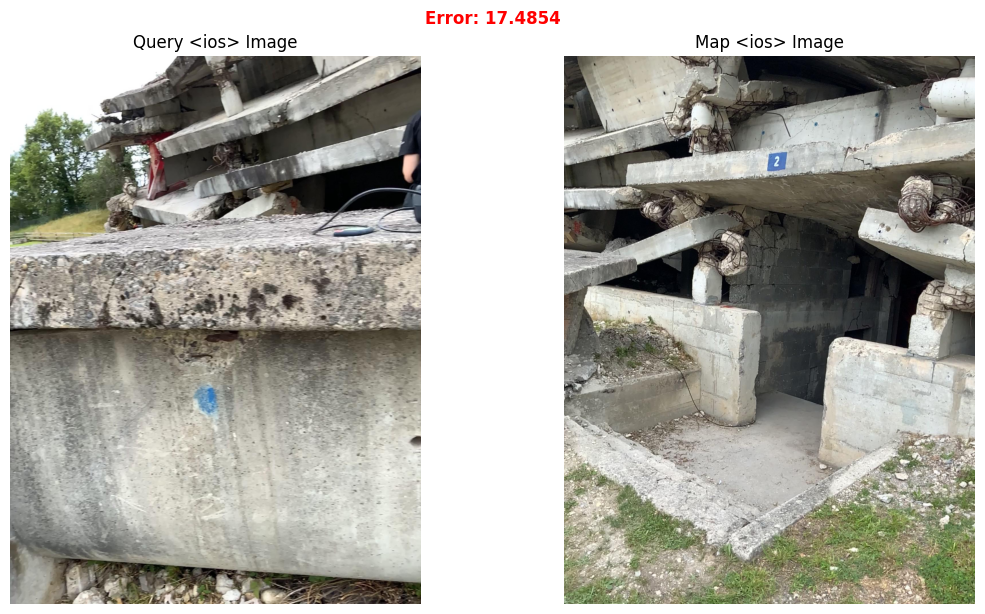

['ios_2023-07-14_09.58.15_000/images/2515675158.jpg'
 'ios_2023-07-14_09.23.15_000/images/602711653.jpg' '109.12015512906784'
 '0.004591175']


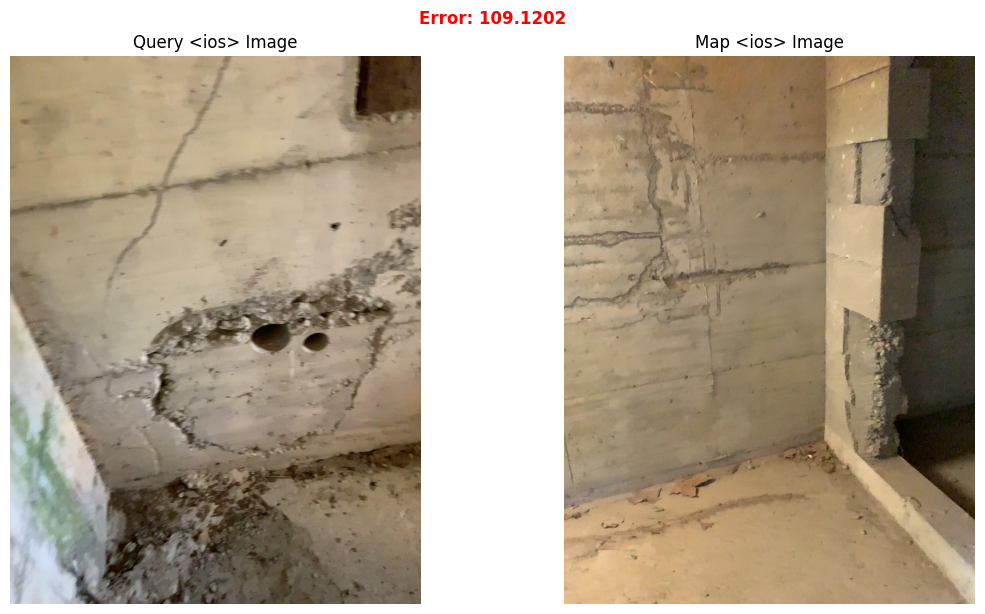

['ios_2023-07-13_14.42.15_000/images/291115740.jpg'
 'ios_2023-07-12_20.51.17_000/images/5139214551.jpg' '19.215076497002908'
 '0.009367669']


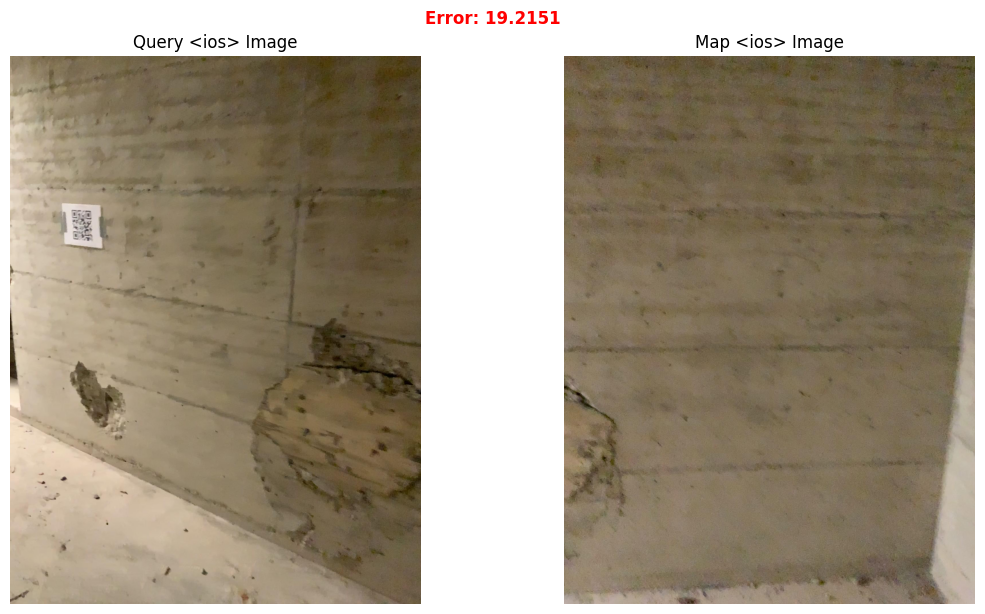

['ios_2023-07-14_09.58.15_000/images/2508061821.jpg'
 'ios_2024-07-04_09.51.03_000/images/67057580037.jpg' '12.940739036124963'
 '0.11933442']


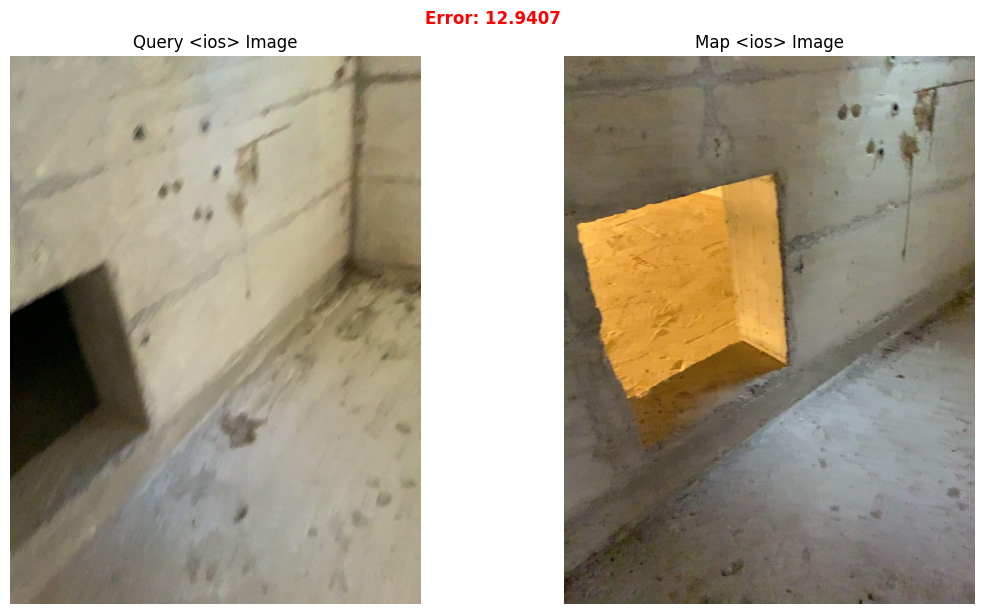

['ios_2024-07-03_13.54.46_000/images/52314727040.jpg'
 'ios_2023-07-12_20.46.14_002/images/4937041127.jpg' '29.46348663460078'
 '0.080387615']


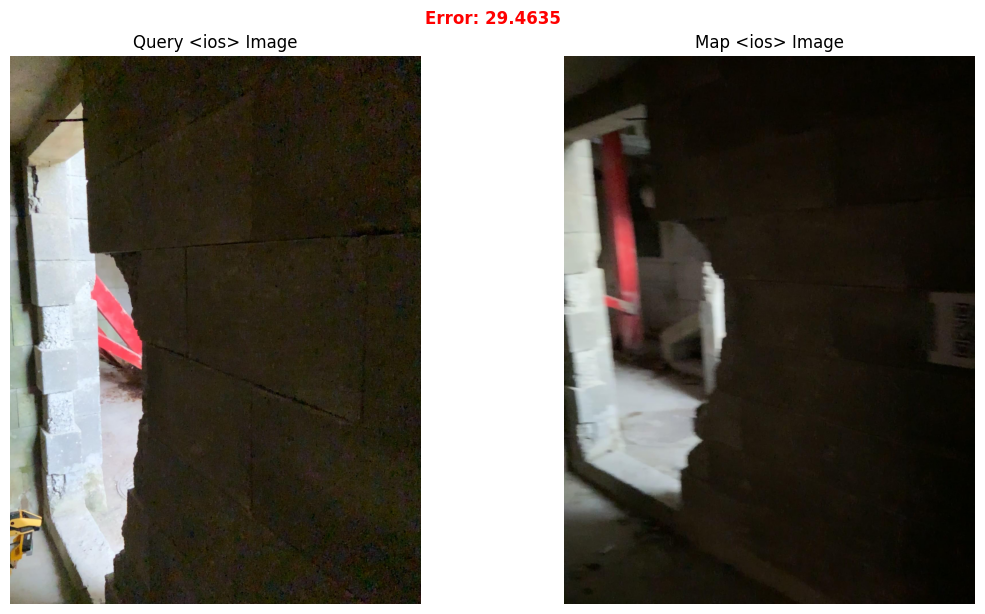

['ios_2024-07-03_13.54.46_000/images/52221084445.jpg'
 'ios_2023-07-14_09.58.15_001/images/2570684443.jpg' '17.32338606962409'
 '0.15121733']


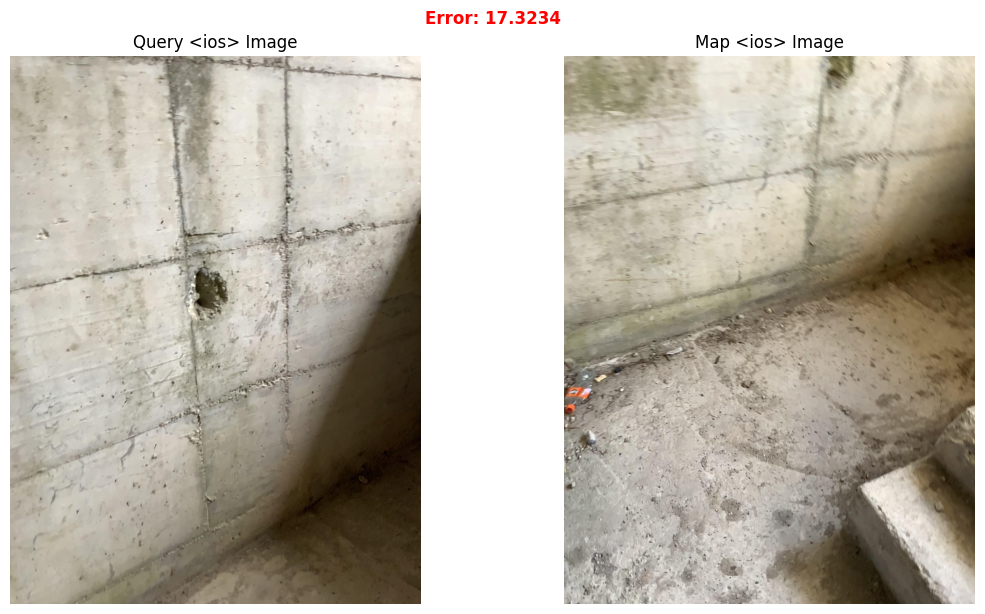

['ios_2023-07-14_09.58.15_000/images/2493234972.jpg'
 'ios_2024-07-03_13.49.13_000/images/51875794600.jpg' '6.448194905546431'
 '0.137422']


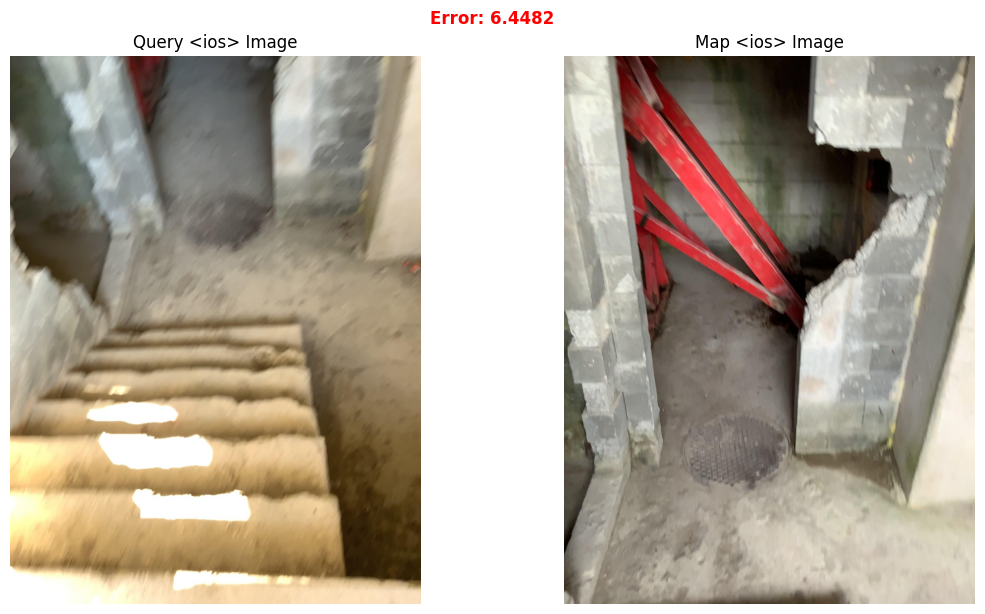

['ios_2023-07-12_20.46.14_001/images/4925845999.jpg'
 'ios_2023-07-12_20.54.50_000/images/5330623764.jpg' '84.21110681870692'
 '0.01229633']


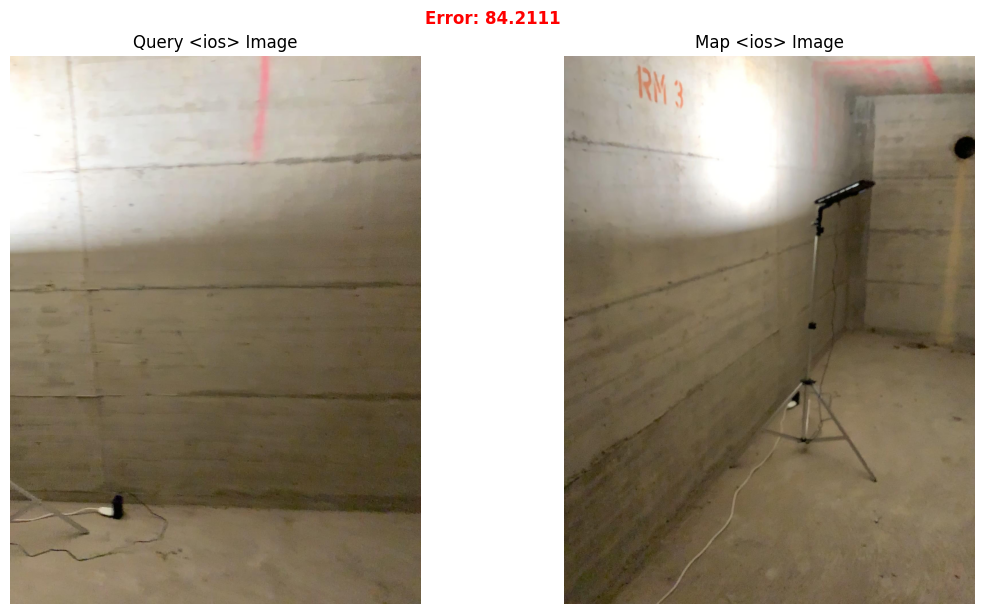

['ios_2024-07-03_13.54.46_000/images/52231896408.jpg'
 'ios_2024-07-03_13.49.13_000/images/51884790691.jpg' '8.178420041941148'
 '0.37144852']


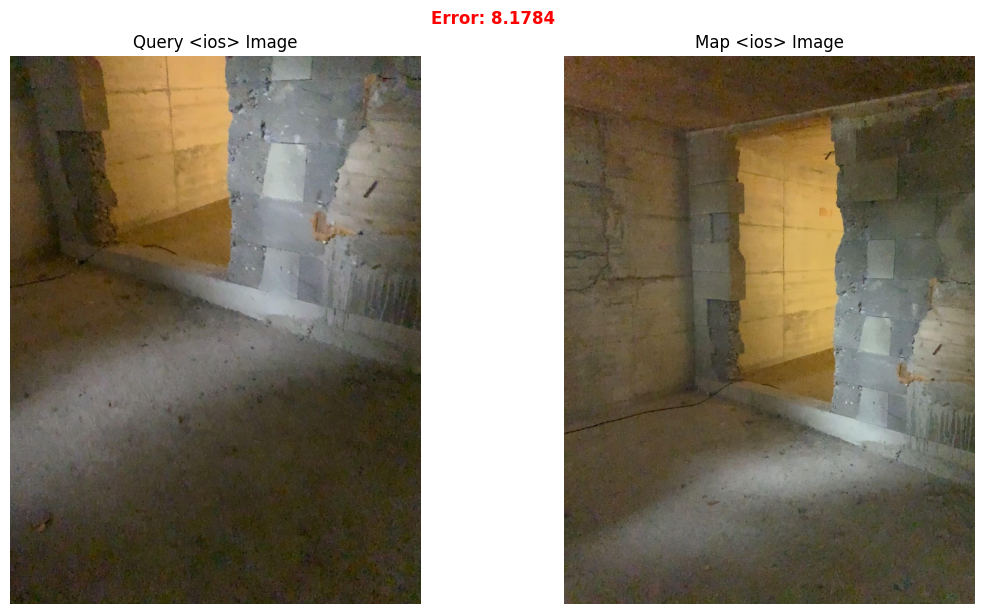

['ios_2023-07-13_14.42.15_000/images/279704144.jpg'
 'ios_2023-07-12_20.51.17_000/images/5133017251.jpg' '45.2896816212688'
 '0.05326235']


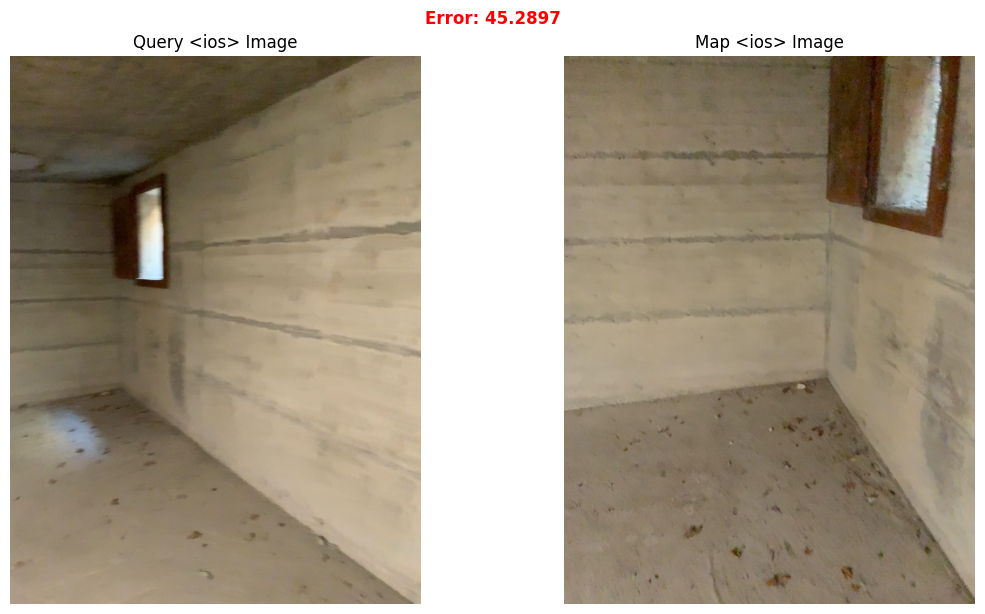

In [ ]:
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import threading

    
def plot_cam_frustum(K, width, height, color=[255, 255, 255], scale=0.1):
    # 1. Image corner pixel coordinates (in homogeneous form)
    corners_px = np.array([
        [0,     0,      1],  # top-left
        [width, 0,      1],  # top-right
        [width, height, 1],  # bottom-right
        [0,     height, 1]   # bottom-left
    ]).T  # shape (3, 4)

    # 2. Backproject to normalized 3D rays
    K_inv = np.linalg.inv(K)
    rays = K_inv @ corners_px
    rays /= rays[2, :]  # normalize so z=1
    rays *= scale       # scale to desired depth

    # 3. Camera center
    cam_center = np.zeros((3, 1))  # (3, 1)

    # 4. All points: cam center + 4 corners
    points = np.hstack((cam_center, rays))  # shape (3, 5)
    points = points.T  # shape (5, 3)

    # 5. Define lines: from center to corners, and corners to each other
    lines = [
        [0, 1], [0, 2], [0, 3], [0, 4],  # camera center to corners
        [1, 2], [2, 3], [3, 4], [4, 1]   # image plane rectangle
    ]

    # 6. Colors for each line
    colors = [color for _ in lines]

    # 7. Create Open3D LineSet
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines)
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)

    return line_set

def get_T_from_pose_matrix(pose_matrix):
    return pose_matrix[:3, 3]
    
def plot_cam(vis, cam_pose, K, w, h, color):
    frustum = plot_cam_frustum(K, w, h, color)
    frustum.transform(cam_pose)
    vis.add_geometry(frustum)
    return vis

def visualize_pairs(pair, est_poses, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs):
    vis = o3d.visualization.Visualizer()
    query_img, map_img, *_ = pair
    vis.create_window()
    # Prepare
    q_ts, q_sensor = q_imgs[query_img]['timestamp'],  q_imgs[query_img]['sensor_id']
    m_ts, m_sensor = m_imgs[map_img]['timestamp'],  m_imgs[map_img]['sensor_id']
    
    if f"{q_ts}-{m_ts}" not in est_poses: return
    
    est_pose = est_poses[f"{q_ts}-{m_ts}"]['pose']
    query_pose = get_groundtruth(query_poses, q_rigs, q_ts, q_sensor)
    map_pose = get_groundtruth(map_poses, m_rigs, m_ts, m_sensor)
    
    est_pose = map_pose @ est_pose
    
    qK, qw, qh = qKs[q_sensor].values()
    mK, mw, mh = mKs[m_sensor].values()
    
    # Vis cam
    vis = plot_cam(vis, est_pose, qK, qh, qw, [255, 0, 0])
    vis = plot_cam(vis, query_pose, qK, qh, qw, [0, 255, 0])
    vis = plot_cam(vis, map_pose, mK, mh, mw, [0, 0, 255])
    
    opt = vis.get_render_option()
    opt.line_width = 10
    opt.background_color = np.array([0, 0, 0])
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
    vis.add_geometry(axis)
    vis.run()
    vis.clear_geometries()
    vis.destroy_window()
        
def show_img_pair(pair, capture):
    query_img_path, map_img_path, error, *_ = pair
    error = float(error)

    query_img_path = f"{capture}/ARCHE_D2/sessions/{query_device}_query/raw_data/{query_img_path}"
    map_img_path = f"{capture}/ARCHE_D2/sessions/{map_device}_map/raw_data/{map_img_path}"
    
    query_img = Image.open(query_img_path)
    map_img = Image.open(map_img_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(query_img)
    axs[0].set_title(f"Query <{query_device}> Image")
    axs[0].axis('off')

    axs[1].imshow(map_img)
    axs[1].set_title(f"Map <{map_device}> Image")
    axs[1].axis('off')

    fig.text(0.5, 1, f'Error: {error:.4f}', ha='center', va='center', fontsize=12, color='red', weight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

def load_pairs(file_path, sample=10):
    with open(file_path, 'r', encoding='utf-8') as f:
        pairs = []
        for line in f:
            if line.startswith("#"): continue
            pair = line.strip().split(', ')
            pairs.append(tuple(pair))
        samples = np.random.choice(range(len(pairs)), sample)
        pairs = np.array(pairs)[samples]
        return pairs
        
#########################################
capture = "/home/long/Workspace/crocodl-benchmark/capture"
query_device = 'ios'
map_device = 'ios'
group = 'bad'
sample = 10

# Pairs
PAIRS_PATH = f"/home/long/Workspace/crocodl-benchmark/notebooks/estimate_pose/{query_device}_query/{map_device}_map/{group}_pairs.txt"
pairs = load_pairs(PAIRS_PATH, sample)

# Images
QUERY_IMAGES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/images.txt"
MAP_IMAGES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/images.txt"
q_imgs = load_images(QUERY_IMAGES_PATH)
m_imgs = load_images(MAP_IMAGES_PATH)

SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
SAVE_PATH = f"{SAVE_DIR}/est_poses.txt"
est_poses = load_poses(SAVE_PATH)
    
# Poses
QUERY_POSES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
MAP_POSES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
query_poses = load_poses(QUERY_POSES_PATH)
map_poses = load_poses(MAP_POSES_PATH)

# Rigs
QUERY_RIGS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
MAP_RIGS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
q_rigs = load_rigs(QUERY_RIGS_PATH)
m_rigs = load_rigs(MAP_RIGS_PATH)

QUERY_SENSORS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
MAP_SENSORS_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
qKs = load_intrinsics(QUERY_SENSORS_PATH)
mKs = load_intrinsics(MAP_SENSORS_PATH)

for pair in pairs:
    print(pair)
    show_img_pair(pair, capture)
    thread = threading.Thread(
        target=visualize_pairs, 
        args=(pair, est_poses, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs)
    )
    thread.start()